# OpenQAOA: ideal vs. noisy vs. ZNE mitigated

We will execute QAOA workflows for a maxcut instance. This workflow was taken from the following tutorial https://el-openqaoa.readthedocs.io/en/main/notebooks/01_workflows_example.html .

There will be three workflows:

1. An ideal workflow, which will be exactly the same as the one of OpenQAOA tutorial
2. A noisy workflow, with some depolarizing noise whose noise rates were taken from ibm_osaka
3. A ZNE mitigated workflow. For this one, we will add the same ibm_osaka noise model, but also adding the ZNE mitigation technique from Mitiq. The calibration data used was taken from the following tutorial https://mitiq.readthedocs.io/en/stable/guide/zne-1-intro.html

The idea of this notebook is to test our integration of Mitiq ZNE technique into OpenQAOA.

## Step 1: Create a problem instance


In [15]:
#some regular python libraries
import networkx as nx
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#import problem classes from OQ for easy problem creation
from openqaoa.problems import MaximumCut, NumberPartition

#import the QAOA workflow model
from openqaoa import QAOA

#import method to specify the device
from openqaoa.backends import create_device

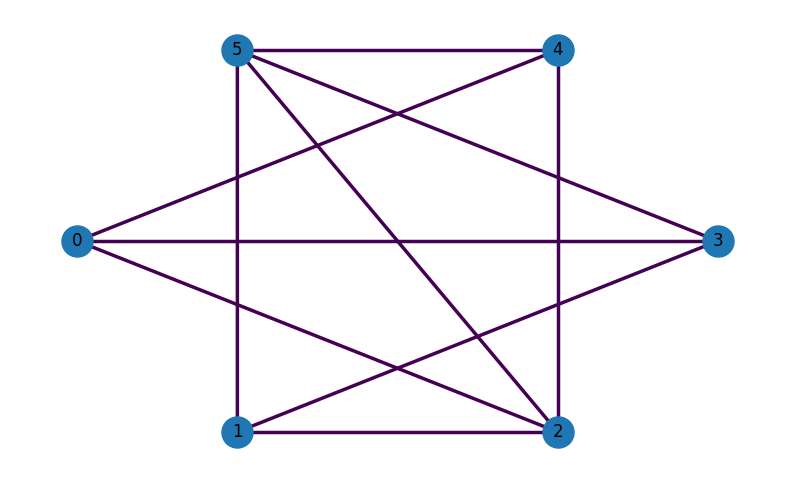

In [16]:
nodes = 6
edge_probability = 0.6
g = nx.generators.fast_gnp_random_graph(n=nodes, p=edge_probability, seed=42)

# import graph plotter from openqaoa
from openqaoa.utilities import plot_graph
plot_graph(g)

In [17]:
# Use the MaximumCut class to instantiate the problem.
maxcut_prob = MaximumCut(g)

# The property `qubo` translates the problem into a binary Qubo problem.
# The binary values can be access via the `asdict()` method.
maxcut_qubo = maxcut_prob.qubo

### Extract the exact solution for a small enough problem

In [18]:
hamiltonian = maxcut_qubo.hamiltonian

# import the brute-force solver to obtain exact solution
from openqaoa.utilities import ground_state_hamiltonian
energy, configuration = ground_state_hamiltonian(hamiltonian)
print(f"Ground State energy: {energy}, Solution: {configuration}")

Ground State energy: -6.0, Solution: ['001110', '110001']


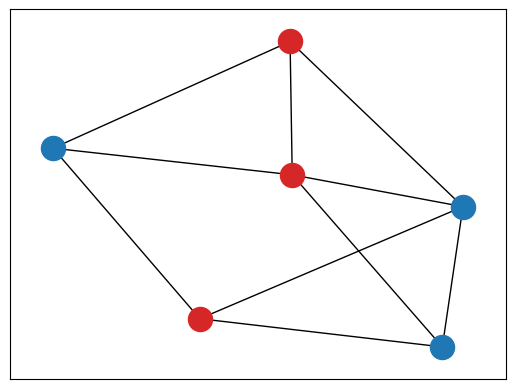

In [19]:
#plot the solution on graph
g_sol = np.copy(g)
pos =  nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(g, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(g, pos)

## Step 2: Build the QAOA models


In [82]:
q_ideal = QAOA()
q_noisy = QAOA()
q_mitigated = QAOA()

### Creating the noise model

In [83]:
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

one_qubit_gates = ['h','rx']
two_qubits_gates = ['rzz']

#create depol. noise
def add_depolarizing_error(noise_model,prob1,prob2):
    noise_model = add_one_qubit_depolarizing_error(noise_model,prob1)
    noise_model = add_two_qubits_depolarizing_error(noise_model,prob2)
    return noise_model

#create 1 qubit depol. noise
def add_one_qubit_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 1)
    noise_model.add_all_qubit_quantum_error(error,one_qubit_gates)
    return noise_model

#create 2 qubits depol.noise
def add_two_qubits_depolarizing_error(noise_model,prob):
    error = depolarizing_error(prob, 2)
    noise_model.add_all_qubit_quantum_error(error, two_qubits_gates)
    return noise_model

#noise rates took from ibm_osaka, Median SX error, 23/1/2024
noise_model = add_depolarizing_error(NoiseModel(),0.05,0.05)
#display(noise_model.to_dict())

### Ideal QAOA model

In [84]:
# optionally configure the following properties of the model

# device
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q_ideal.set_device(qiskit_device)

# circuit properties
q_ideal.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q_ideal.set_backend_properties(prepend_state=None, append_state=None)

# classical optimizer properties
q_ideal.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

## Noisy QAOA model

In [85]:
# optionally configure the following properties of the model

# device
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q_noisy.set_device(qiskit_device)

# circuit properties
q_noisy.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q_noisy.set_backend_properties(prepend_state=None, append_state=None,noise_model=noise_model)

# classical optimizer properties
q_noisy.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

### ZNE mitigated QAOA model

In [86]:
# optionally configure the following properties of the model

# device
qiskit_device = create_device(location='local', name='qiskit.shot_simulator')
q_mitigated.set_device(qiskit_device)

# circuit properties
q_mitigated.set_circuit_properties(p=2, param_type='standard', init_type='rand', mixer_hamiltonian='x')

# backend properties (already set by default)
q_mitigated.set_backend_properties(prepend_state=None, append_state=None,noise_model=noise_model)

q_mitigated.set_error_mitigation_properties(error_mitigation_technique='mitiq_zne',calibration_data_location="caldata.json")

# classical optimizer properties
q_mitigated.set_classical_optimizer(method='nelder-mead', maxiter=200, tol=0.001,
                          optimization_progress=True, cost_progress=True, parameter_log=True)

### Getting the results

In [ ]:
import json

q_ideal.compile(maxcut_qubo)
q_noisy.compile(maxcut_qubo)
q_mitigated.compile(maxcut_qubo)

q_ideal.optimize()
q_ideal_result = q_ideal.result
with open('maxcutqaoa_ideal.json', 'w') as archivo:
    json.dump(q_ideal_result.asdict(), archivo)

q_noisy.optimize()
q_noisy_result = q_noisy.result
with open('maxcutqaoa_noisy.json', 'w') as archivo:
    json.dump(q_noisy_result.asdict(), archivo)

q_mitigated.optimize()
q_mitigated_result = q_mitigated.result
with open('maxcutqaoa_mitigated.json', 'w') as archivo:
    json.dump(q_mitigated_result.asdict(), archivo)


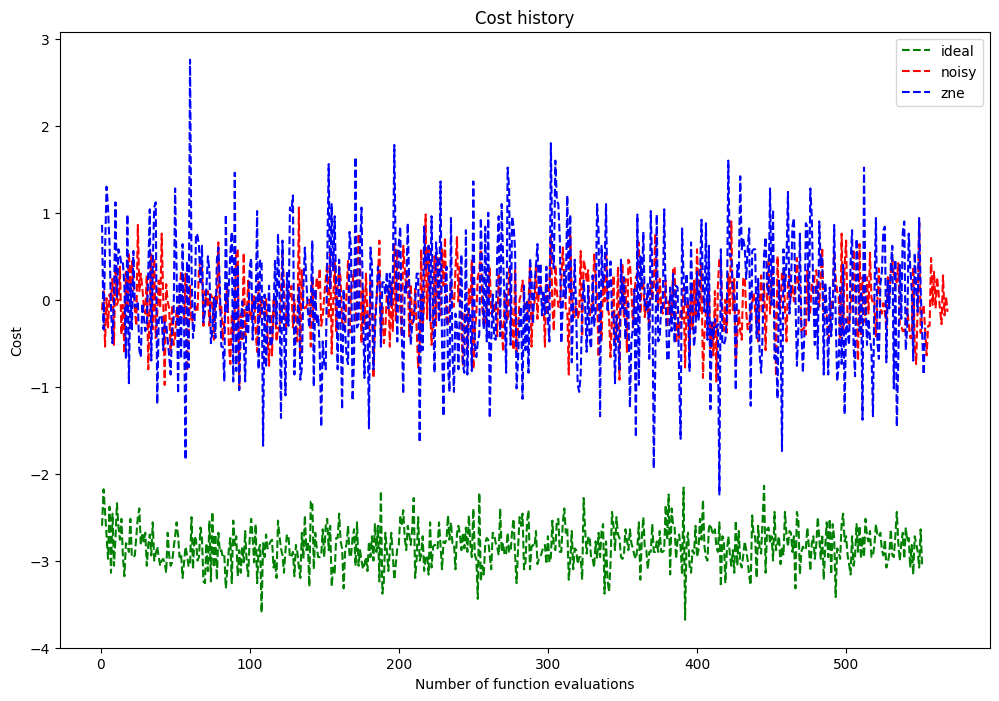

In [89]:
fig, ax = plt.subplots(figsize=(12,8))
q_ideal_result.plot_cost(ax=ax,color='green',label='ideal')
q_noisy_result.plot_cost(ax=ax,color='red',label='noisy')
q_mitigated_result.plot_cost(ax=ax,color='blue',label='zne')
plt.savefig('costhistory', bbox_inches='tight')